In [110]:
import os
import numpy as np
import nibabel as nib
import torchio.data
from tqdm import tqdm
from torch.utils.data import Dataset
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import Normalize, ImagePair, calculate_overlap, data_split, RealImage, real_data
import torchvision
from models.generator import GeneratorRRDB
from models.generator_small import GeneratorRRDBSmall
from models.discriminator import Discriminator
from models.feature_extractor import FeatureExtractor

from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
import pytorch_lightning as pl

from torchvision.utils import save_image
from torchsummary import summary
import time
from utils import save_subject
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import normalized_root_mse as NRSME

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
std = 0.3548

In [5]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)
discriminator = Discriminator(input_shape=(1, 64, 64))
feature_extractor = FeatureExtractor()

In [21]:
#summary(generator, input_size=(1, 64, 64), batch_size=16, device='cpu')

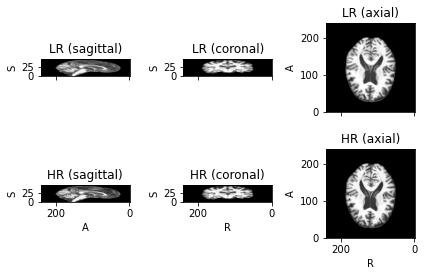

In [22]:
img_real = ImagePair(number=1, simulated=False, select_slices=48)
real_subject = [img_real.subject()]
real_set = tio.SubjectsDataset(
    real_subject, transform=Normalize(std=std))

real_set[0].plot()

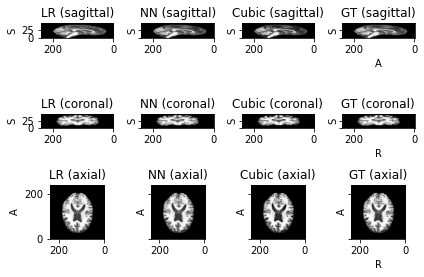

In [108]:
img_real = RealImage(number=1, select_slices=48)
real_subject = [img_real.subject()]
real_set = tio.SubjectsDataset(
    real_subject, transform=Normalize(std=std))

real_set[0].plot()

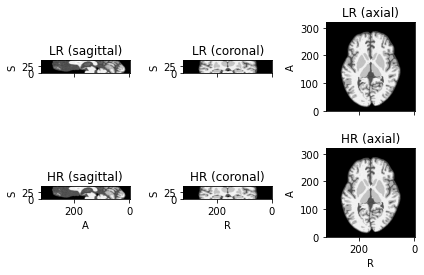

In [83]:
img_sim = ImagePair(number=100206, simulated=True, select_slices=70)
sim_subject = [img_sim.subject()]

sim_set = tio.SubjectsDataset(
    sim_subject, transform=Normalize(std=std))

sim_set[0].plot()

In [114]:
test_subjects = data_split('test', patients_frac=1, root_dir='data', datasource='2mm_1mm')
# test_subjects = [test_subjects[0]]

test_set = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading test set...


TypeError: __init__() got an unexpected keyword argument 'dataset'

In [144]:
test_subjects = real_data(root_dir='data', numslices=30)
# test_subjects = [test_subjects[0]]

test_set = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading real dataset...


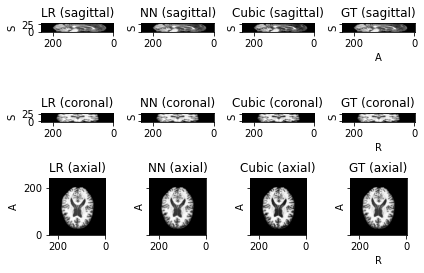

(1, 240, 240, 30)
(1, 240, 240, 30)
(1, 240, 240, 30)
(1, 240, 240, 30)


In [145]:
test_set[0].plot()
print(test_set[0]['LR'].shape)
print(test_set[0]['NN'].shape)
print(test_set[0]['Cubic'].shape)
print(test_set[0]['GT'].shape)

In [84]:
source = 'sim'

if source == 'sim':
    img = sim_set
elif source == 'real':
    img = real_set

In [44]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# device = torch.device("cpu")

root = '/mnt/beta/djboonstoppel/Code'

### Tune
exp_name = 'baselines'
config = {
    'optimizer': 'adam',
    'b1': 0.9,
    'b2': 0.5,
    'batch_size': 16,
    'num_filters': 64,
    'learning_rate': 1e-4,
    'patch_size': 64,
    'alpha_content': 0,
    'alpha_adversarial': 0.1,
    'ragan': False,
    'gan_mode': 'vanilla',
    'edge_loss': 2,
    'netD_freq': 1,
    'datasource': '2mm_1mm',
    'patients_frac': 0.5,
    'patch_overlap': 0.5,
}
epoch = 66
ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(config['alpha_adversarial'], epoch)
path = os.path.join(root, 'experiments', exp_name, 'checkpoints', ckpt_fname)

# ### Log
# exp_name = 'fixed'
# version = 0
# epoch = 155
# cktp_fname = exp_name + '-checkpoint-epoch={}.ckpt'.format(epoch)
# path = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), cktp_fname)

### Log
# exp = 'less_params'
# exp_name = 'conv4_filters32'
# ckpt = 'numconv4_filters32'
# epoch = 144
# cktp_fname = ckpt + '-checkpoint-epoch={}.ckpt'.format(epoch)
# path = os.path.join(root, 'experiments', exp, exp_name, cktp_fname)

# model = LitTrainer_org.load_from_checkpoint(netG=generator,
#                                             netF=feature_extractor,
#                                             checkpoint_path=path)
model = LitTrainer_gan.load_from_checkpoint(netG=generator,
                                            netF=feature_extractor,
                                            netD=discriminator,
                                            checkpoint_path=path,
                                            config=config,
                                            )
print(model.hparams)
model.to(device)
model.eval()
model.freeze()

"args":   Namespace(std=0.3548, num_workers=4, root_dir='/mnt/beta/djboonstoppel/Code', name='alpha_adv', num_samples=1, patch_size=64, warmup_batches=1000, logger=True, checkpoint_callback=None, enable_checkpointing=True, default_root_dir=None, gradient_clip_val=None, gradient_clip_algorithm=None, process_position=0, num_nodes=1, num_processes=1, devices=None, gpus=None, auto_select_gpus=False, tpu_cores=None, ipus=None, log_gpu_memory=None, progress_bar_refresh_rate=None, enable_progress_bar=True, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=None, max_epochs=-1, min_epochs=None, max_steps=-1, min_steps=None, max_time='00:16:00:00', limit_train_batches=1.0, limit_val_batches=1.0, limit_test_batches=1.0, limit_predict_batches=1.0, val_check_interval=1.0, flush_logs_every_n_steps=None, log_every_n_steps=50, accelerator=None, strategy=None, sync_batchnorm=False, precision=32, enable_model_summary=True, weights_summary='to

In [49]:
batch_size = model.hparams.config['batch_size']

patch_size = (model.hparams.config['patch_size'],model.hparams.config['patch_size'])
ovl_perc = (model.hparams.config['patch_overlap'], model.hparams.config['patch_overlap'])
overlap, nr_patches = calculate_overlap(test_set[0]['LR'].data, patch_size, ovl_perc)

In [50]:
subject = test_set[0]
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size=(*patch_size,1),
    patch_overlap=overlap,
    padding_mode=0,
)

patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=model.hparams.config['batch_size'])

Inference time: 6.40 s


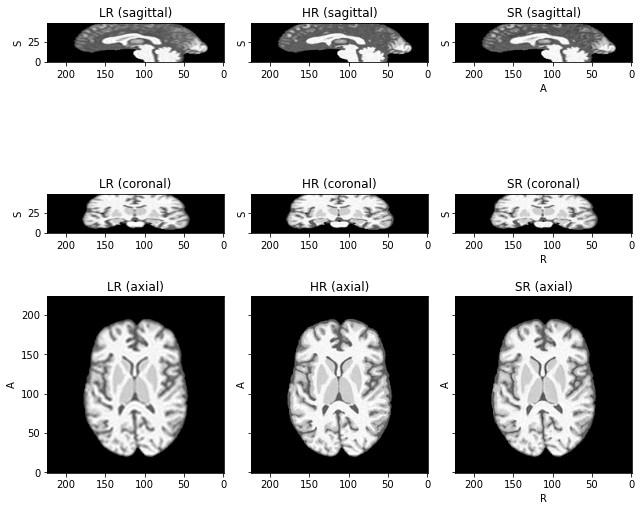

In [14]:
start_time = time.time()

aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
with torch.no_grad():
    for patches_batch in patch_loader:
        imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
        gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
        locations = patches_batch[tio.LOCATION]
        aggregator.add_batch(gen_hr, locations)

foreground = aggregator.get_output_tensor()

end_time = time.time()
print('Inference time: {:.2f} s'.format(end_time - start_time))

generated = tio.ScalarImage(tensor=foreground)
subject.add_image(generated, 'SR')
subject.plot(figsize=(9, 8))
torch.cuda.empty_cache()

In [87]:
# gen_hr = subject['SR'].numpy()[0]
# gen_hr_nifty = nib.Nifti1Image(gen_hr, affine=img.subject()['HR'].affine, header=img.info()['HR'])
# nib.save(gen_hr_nifty, 'test.nii.gz')

if source == 'sim':
    img_source = img_sim
elif source == 'real':
    img_source = img_real

# fname ='img_{}_{}'.format(config['ragan'], config['optimizer'])
# output_path = os.path.join(root, exp_name, 'output', source)

# fname = 'img_{}_{}_{}'.format(config['optimizer'], config['alpha_content'], config['alpha_adversarial'])
# output_path = os.path.join(root, 'experiments', exp_name, 'output', source)

# fname = 'img_{}'.format(exp_name)
# output_path = os.path.join(root, 'experiments', exp, 'output', source)

fname = 'scores'
output_path = os.path.join(root, 'output', 'scores')

os.makedirs(output_path, exist_ok=True)
# name='100206'
std = std
max_vals = (
    img_source.info()['LR']['scaling'],
    img_source.info()['HR']['scaling'],
    img_source.info()['LR']['scaling'],
    )
save_subject(subject=subject,
             header=img_source.info()['LR']['header'],
             pref=fname,
             std=std,
             max_vals=max_vals,
             path=output_path,
             source = source,
             )

In [51]:
def NCC(real_image, generated_image):
    """Method to compute the normalised cross correlation between two images.
    Arguments:
                real_image:       (numpy array) the real image
                predicted_image:  (numpy array) the predicted image by the model
    Returns:
                NCCScore:         (float) the normalised cross correlation score
    """
    # if the images are not the same size, raise an error
    if real_image.shape != generated_image.shape:
        raise AssertionError("The inputs must be the same size.")
    # reshape images to vectors
    u = real_image.reshape((real_image.shape[0]*real_image.shape[1]*real_image.shape[2],1))
    v = generated_image.reshape((generated_image.shape[0]*generated_image.shape[1]*real_image.shape[2],1))
    # take the real image and subtract the mean of the real image
    u = u - u.mean(keepdims=True)
    # take the generated image and subtract the mean of the generated image
    v = v - v.mean(keepdims=True)
    # transpose the real image for multiplication
    TransposedU = np.transpose(u)
    # calculate the length of the image
    length = np.linalg.norm(u,ord=2)*np.linalg.norm(v,ord=2)
    # calculate the NCC of the real image and the generated image
    NCCScore = float(TransposedU.dot(v))/length
    # return the NCC score
    return NCCScore

def get_scores(real, gen):
    ncc = NCC(real, gen)
    ssim = SSIM(real.squeeze(), gen.squeeze(), gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
    nrmse = NRSME(real, gen)
    return ncc, ssim, nrmse

In [146]:
test_subjects_new = []
for subject in tqdm(test_set):

    grid_sampler = tio.inference.GridSampler(
        subject,
        patch_size=(*patch_size,1),
        patch_overlap=overlap,
        padding_mode=0,
    )

    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=model.hparams.config['batch_size'])

    aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
    with torch.no_grad():
        for patches_batch in patch_loader:
            imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['GT'][tio.DATA].squeeze(4)
            gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
            locations = patches_batch[tio.LOCATION]
            aggregator.add_batch(gen_hr, locations)

    foreground = aggregator.get_output_tensor()
    generated = tio.ScalarImage(tensor=foreground)
    subject.add_image(generated, 'SR')
    test_subjects_new.append(subject)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:41<00:00,  5.92s/it]


In [94]:
scores_slice = {
    'NCC': {
        'LR': [],
        'SR': [],
    },
    'SSIM': {
        'LR': [],
        'SR': [],
    },
    'NRSME': {
        'LR': [],
        'SR': [],
    },
}

test_subject_new = test_subjects_new[0]
for i in range(len(test_subjects_new)):
    for j in range(test_subjects_new[i]['LR'].data.shape[3]):
        LR_slice = test_subjects_new[i]['LR'].data[:,:,:,[j]].squeeze(0)*std
        HR_slice = test_subjects_new[i]['HR'].data[:,:,:,[j]].squeeze(0)*std
        SR_slice = test_subjects_new[i]['SR'].data[:,:,:,[j]].squeeze(0)*std
        ncc_lr, ssim_lr, nrmse_lr = get_scores(HR_slice.numpy(), LR_slice.numpy())
        ncc_sr, ssim_sr, nrmse_sr = get_scores(HR_slice.numpy(), SR_slice.numpy())

        scores_slice['NCC']['LR'].append(ncc_lr)
        scores_slice['NCC']['SR'].append(ncc_sr)
        scores_slice['SSIM']['LR'].append(ssim_lr)
        scores_slice['SSIM']['SR'].append(ssim_sr)
        scores_slice['NRSME']['LR'].append(nrmse_lr)
        scores_slice['NRSME']['SR'].append(nrmse_sr)

In [88]:
scores = {
    'NCC': {
        'LR': [],
        'SR': [],
    },
    'SSIM': {
        'LR': [],
        'SR': [],
    },
    'NRSME': {
        'LR': [],
        'SR': [],
    },
}

test_subject_new = test_subjects_new[0]
for i in range(len(test_subjects_new)):
    # for j in range(test_subjects_new[i]['LR'].data.shape[3]):
    LR = test_subjects_new[i]['LR'].data.squeeze(0)*std
    HR = test_subjects_new[i]['HR'].data.squeeze(0)*std
    SR = test_subjects_new[i]['SR'].data.squeeze(0)*std
    ncc_lr, ssim_lr, nrmse_lr = get_scores(HR.numpy(), LR.numpy())
    ncc_sr, ssim_sr, nrmse_sr = get_scores(HR.numpy(), SR.numpy())

    scores['NCC']['LR'].append(ncc_lr)
    scores['NCC']['SR'].append(ncc_sr)
    scores['SSIM']['LR'].append(ssim_lr)
    scores['SSIM']['SR'].append(ssim_sr)
    scores['NRSME']['LR'].append(nrmse_lr)
    scores['NRSME']['SR'].append(nrmse_sr)

In [147]:
scores_real = {
    'NCC': {
        'NN': [],
        'Cubic': [],
        'SR': [],
    },
    'SSIM': {
        'NN': [],
        'Cubic': [],
        'SR': [],
    },
    'NRSME': {
        'NN': [],
        'Cubic': [],
        'SR': [],
    },
}

for i in range(len(test_subjects_new)):
    for j in range(test_subjects_new[i]['LR'].data.shape[3]):
        NN = test_subjects_new[i]['NN'].data[:,:,:,[j]].squeeze(0)*std
        CB = test_subjects_new[i]['Cubic'].data[:,:,:,[j]].squeeze(0)*std
        GT = test_subjects_new[i]['GT'].data[:,:,:,[j]].squeeze(0)*std
        SR = test_subjects_new[i]['SR'].data[:,:,:,[j]].squeeze(0)*std
        ncc_nn, ssim_nn, nrmse_nn = get_scores(GT.numpy(), NN.numpy())
        ncc_cb, ssim_cb, nrmse_cb = get_scores(GT.numpy(), CB.numpy())
        ncc_sr, ssim_sr, nrmse_sr = get_scores(GT.numpy(), SR.numpy())

        scores_real['NCC']['NN'].append(ncc_nn)
        scores_real['NCC']['Cubic'].append(ncc_cb)
        scores_real['NCC']['SR'].append(ncc_sr)
        scores_real['SSIM']['NN'].append(ssim_nn)
        scores_real['SSIM']['Cubic'].append(ssim_cb)
        scores_real['SSIM']['SR'].append(ssim_sr)
        scores_real['NRSME']['NN'].append(nrmse_nn)
        scores_real['NRSME']['Cubic'].append(nrmse_cb)
        scores_real['NRSME']['SR'].append(nrmse_sr)

[Text(1, 0, 'NN'), Text(2, 0, 'Cubic'), Text(3, 0, 'SR')]

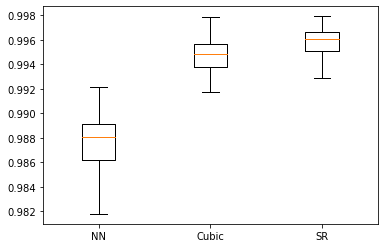

In [148]:
fig, ax = plt.subplots()
fig.set_facecolor('white')
ax.boxplot(scores_real['NCC'].values(), showfliers=False)
ax.set_xticklabels(scores_real['NCC'].keys())

[Text(1, 0, 'NN'), Text(2, 0, 'Cubic'), Text(3, 0, 'SR')]

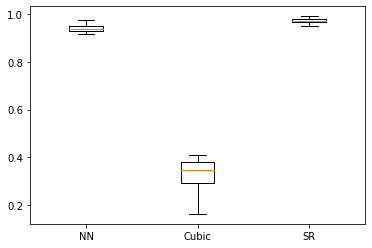

In [151]:
fig, ax = plt.subplots()
fig.set_facecolor('white')
ax.boxplot(scores_real['SSIM'].values(), showfliers=False)
ax.set_xticklabels(scores_real['SSIM'].keys())

[Text(1, 0, 'NN'), Text(2, 0, 'Cubic'), Text(3, 0, 'SR')]

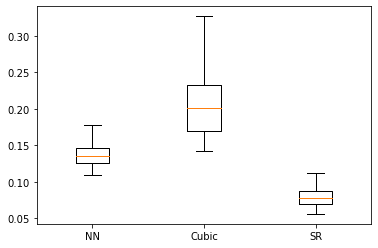

In [152]:
fig, ax = plt.subplots()
fig.set_facecolor('white')
ax.boxplot(scores_real['NRSME'].values(), showfliers=False)
ax.set_xticklabels(scores_real['NRSME'].keys())

In [153]:
len(scores_real['NRSME']['SR'])

210